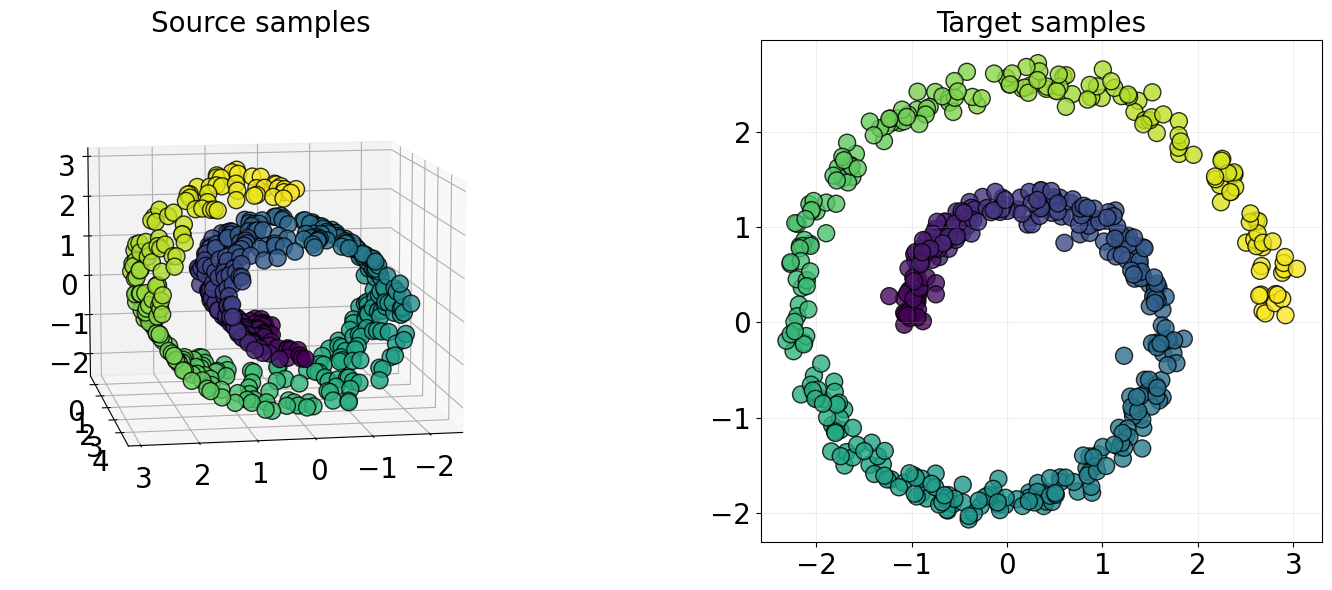

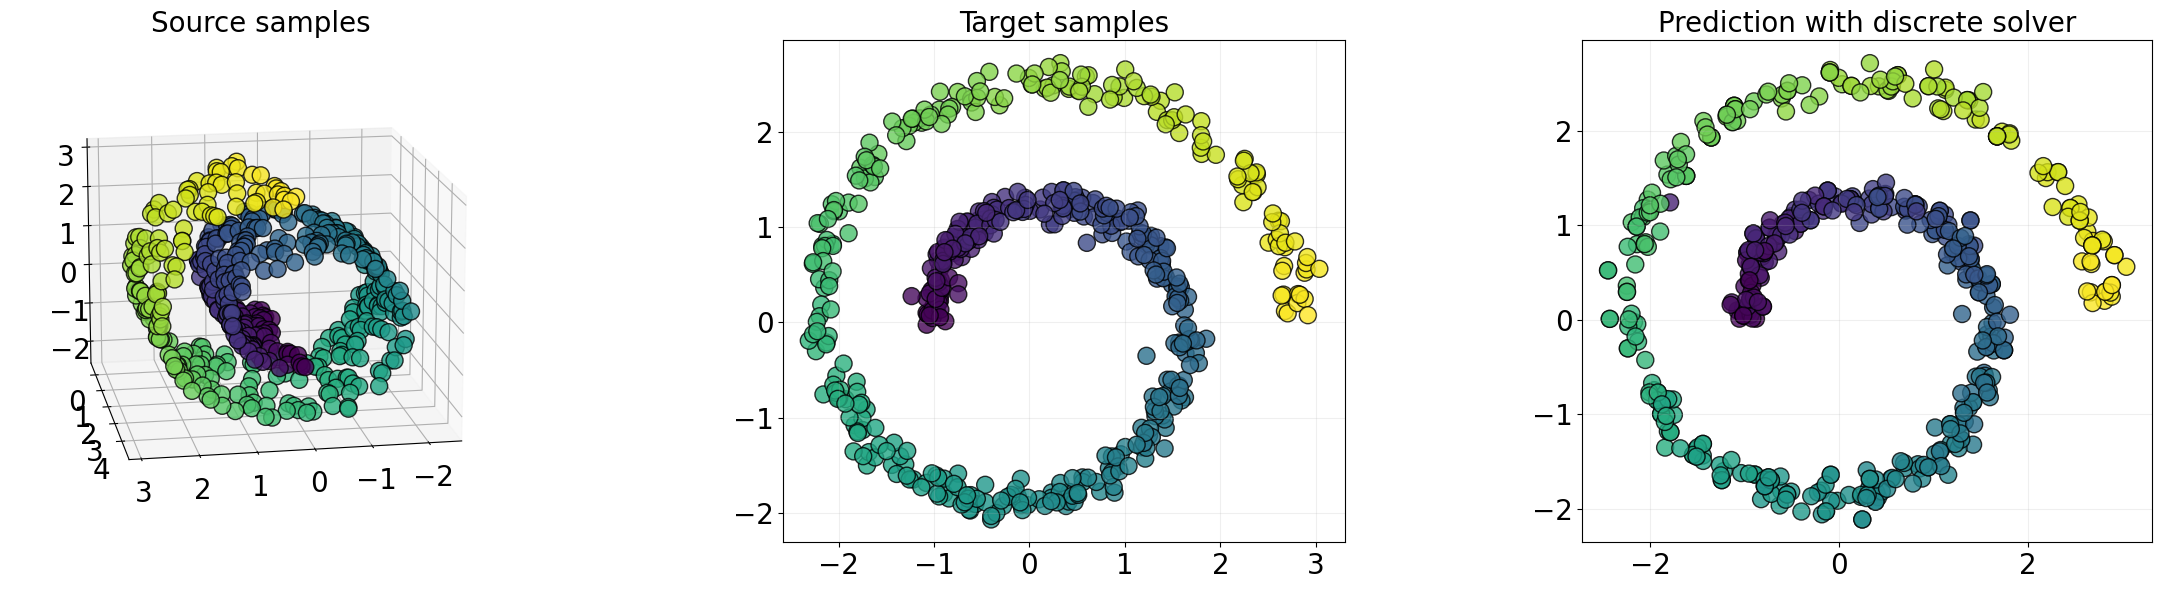

In [72]:
from functools import partial
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.data.data import MixtureNormalSampler
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field
from entot.plotting.plots import plot_1D_balanced
from entot.data.distributions_new import (
    GaussianMixture,
    SklearnDistribution, 
    SphereDistribution,
    RectangleUniform,
    BallUniform,
    Dataset
)
from typing import Optional

from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, acceleration
import numpy as np
import matplotlib.gridspec as gridspec

# %%

def plot_3d(
    fig, gs,
    points, num_subplot, 
    color=None, 
    label=None,
    title=None,
    view_init=None,
    title_size=20,
    legend_size=25,
    tick_size=20,
    lims=None,
    size_points=150,
    alpha=.8,
    set_equal_aspect=False,
    plot_sphere=False,
    plot_hypercube=False,
    n_grid=100
):
    ax = fig.add_subplot(gs[0, num_subplot], projection='3d')
    if view_init is not None:
        ax.view_init(view_init[0], view_init[1])
    ax.scatter(
        points[:, 0],
        points[:, 1],
        points[:, 2],
        c=color,
        edgecolors="k", 
        s=size_points, 
        alpha=alpha,
        label=label
    )
    if lims is not None:
        ax.axes.set_xlim3d(lims[0]) 
        ax.axes.set_ylim3d(lims[1]) 
        ax.axes.set_zlim3d(lims[2]) 
    ax.set_title(title, fontsize=title_size)
    ax.tick_params(axis="both", which="major", labelsize=tick_size)
    ax.grid(alpha=.2)
    # ax.set_position([.15, 0., .15, 0.]) 
    if label is not None:
        ax.legend(fontsize=legend_size)
    if set_equal_aspect:
        set_axes_equal(ax)
    
def plot_2d(
    fig, gs,
    points, 
    num_subplot, 
    color=None,
    label=None, 
    title=None,
    title_size=20,
    legend_size=25,
    tick_size=20,
    lims=None,
    size_points=150,
    alpha=.8,
    set_equal_aspect=False,
):
    # ax = fig.add_subplot(x, y, z)
    ax = fig.add_subplot(gs[0, num_subplot])
    y_coordinates = (
        points[:, 1] if points.shape[1] == 2
        else jnp.zeros(points.shape[0])
    )
    ax.scatter(
        points[:, 0],
        y_coordinates,
        c=color,
        edgecolors="k", 
        s=size_points, 
        alpha=alpha,
        label=label
    )
    if lims is not None:
        ax.set_xlim(lims[0])
        ax.set_ylim(lims[1])
    ax.set_title(title, fontsize=title_size)
    ax.tick_params(axis="both", which="major", labelsize=tick_size)
    ax.grid(alpha=.2)
    if label is not None:
        ax.legend(fontsize=legend_size),
    if set_equal_aspect:
        ax.set_aspect("equal")

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    
    
def plot_fitted_map_gromov(
    batch, 
    num_points=None,
    seed=0,
    show=True,
    return_fig=False,
    title_size=20,
    legend_size=25,
    tick_size=20,
    lims=None,
    size_points=150,
    alpha=.8,
    view_init=None,
    set_equal_aspect_source=False,
    set_equal_aspect_target=False,
    plot_sphere_source=False,
    plot_sphere_target=False,
    plot_hypercube_source=False,
    plot_hypercube_target=False,
    plot_source=True,
    *args,
    **kwargs,
):
    """
    Plot the fitted map on a batch of samples from the source measure.
    """    
    
    assert (
        all(
            [x in batch.keys() for x in ['colors_source', 'colors_target']]
        )
    ), (
        "Provide colors for Gromov Wasserstein map plotting."
    )
    if num_points is None:
        subsample = jnp.arange(len(batch['source']))
    else:
        rng = jax.random.PRNGKey(seed)
        subsample = jax.random.choice(
            rng, a=len(batch['source']), shape=(num_points,),
            replace=False
        )

    num_plots = 2
    if "conditional_discrete" in batch:
        num_plots += 1
    if "conditional_genot" in batch:
        num_plots += 1
    input_dim = batch['source'].shape[-1]
    output_dim = batch['target'].shape[-1]
    
    dims = (
        (input_dim, output_dim) if plot_source
        else (output_dim,)
    )
    assert all(
        [
            x <= 3 for x in dims
        ]
    ), (
        "Plot is only supported for 2D and 3D data."
    )

    fig = plt.figure(figsize=(num_plots*8, 6))
    gs = gridspec.GridSpec(
        1, num_plots, figure=fig,
    )
    source_plotter = (
        plot_2d if input_dim <= 2
        else partial(
            plot_3d, 
            view_init=view_init,
            plot_sphere=plot_sphere_source,
            plot_hypercube=plot_hypercube_source,
        )
    )
    target_plotter = (
        plot_2d if output_dim <= 2
        else partial(
            plot_3d, 
            view_init=view_init,
            plot_sphere=plot_sphere_target,
            plot_hypercube=plot_hypercube_target,
        )
    )
    
    num_subplot = 0
    lim_source = lims['source'] if lims is not None else None
    if lim_source is not None:
        assert len(lim_source) == input_dim, (
            "Provide limits along each dimension. "
            f"Here, source dimension is {input_dim}."
        ) 
    source_plotter(
        fig, gs,
        points=batch["source"][subsample], 
        num_subplot=num_subplot, 
        color=batch["colors_source"][subsample],
        title="Source samples",
        title_size=title_size,
        legend_size=legend_size,
        tick_size=tick_size,
        lims=lim_source,
        alpha=alpha,
        size_points=size_points,
        set_equal_aspect=set_equal_aspect_source
    )
    num_subplot += 1
        
    lim_target = lims['target'] if lims is not None else None
    if lim_target is not None:
        assert len(lim_target) == output_dim, (
            "Provide limits along each dimension. "
            f"Here, source dimension is {output_dim}."
        )
    target_plotter(
        fig, gs,
        points=batch["target"][subsample], 
        num_subplot=num_subplot, 
        color=batch["colors_target"][subsample],
        title="Target samples",
        title_size=title_size,
        legend_size=legend_size,
        tick_size=tick_size,
        lims=lim_target,
        alpha=alpha,
        size_points=size_points,
        set_equal_aspect=set_equal_aspect_target
    )
    num_subplot += 1
    
    if "conditional_discrete" in batch.keys():
        target_plotter(
            fig, gs,
            points=batch["conditional_discrete"][subsample, 0, :], # one sample so take the first by default, 
            num_subplot=num_subplot, 
            color=batch["colors_source"][subsample],
            title="Prediction with discrete solver",
            title_size=title_size,
            legend_size=legend_size,
            tick_size=tick_size,
            lims=lim_target,
            alpha=alpha,
            size_points=size_points,
            set_equal_aspect=set_equal_aspect_target
        )
        num_subplot += 1
        
    if "conditional_genot" in batch.keys():
        target_plotter(
            fig, gs,
            points=batch["conditional_genot"][subsample, 0, :], # one sample so take the first by default
            num_subplot=num_subplot, 
            color=batch["colors_source"][subsample],
            title="Prediction with GENOT",
            title_size=title_size,
            legend_size=legend_size,
            tick_size=tick_size,
            lims=lim_target,
            alpha=alpha,
            size_points=size_points,
            set_equal_aspect=set_equal_aspect_target
        )
        num_subplot += 1
    
    fig.tight_layout()
    if show:
        plt.show()
    plt.close()
    if return_fig:
        return fig

    
# %%

plotter = partial(
    plot_fitted_map_gromov, 
    title_size=20,
    legend_size=25,
    tick_size=20,
    size_points=150,
    set_equal_aspect_source=True,
    set_equal_aspect_target=True,
    num_points=512
)

# %%

source = SklearnDistribution(
    name="swiss",
    dim_data=3,
    noise=0.1,
    scale=.2
)
target = SklearnDistribution(
    name="swiss",
    noise=0.5,
    scale=.2
)

NUM_SAMPLES = 1_024
samples_source, colors_source = source.generate_samples(
    rng=jax.random.PRNGKey(0),
    num_samples=NUM_SAMPLES,
    return_colors=True
)
samples_target, colors_target = target.generate_samples(
    rng=jax.random.PRNGKey(0),
    num_samples=NUM_SAMPLES,
    return_colors=True
)
batch = {
    "source": samples_source,
    "colors_source": colors_source,
    "target": samples_target,
    "colors_target": colors_target,
}

plotter(
    batch=batch, 
    seed=0,
    show=True,
    return_fig=False,
    view_init=(10, 80),
)

# %%

# discrete Gromov-Wasserstein
EPSILON = 1e-2
SCALE_COST = 'mean'
geom_xx = pointcloud.PointCloud(
    x=batch['source'], y=batch['source'],
    epsilon=EPSILON,
    cost_fn=costs.SqEuclidean()
)
geom_yy = pointcloud.PointCloud(
    x=batch['target'], y=batch['target'],
    cost_fn=costs.SqEuclidean()
)
prob = quadratic_problem.QuadraticProblem(
    geom_xx, geom_yy,
    scale_cost=SCALE_COST,
)
solver = gromov_wasserstein.GromovWasserstein(
    epsilon=EPSILON,
    # momentum=acceleration.Momentum(value=1., start=10) # remove momentum if instability
)
out = solver(
    prob,
)

# %%

n = len(batch['source'])
cond_probs = n * out.matrix
k_samples_per_x = 10
sample_cond_from_index = lambda i: jax.random.choice(
    key=jax.random.PRNGKey(i),
    a=batch["target"],
    p=cond_probs[i],
    shape=(k_samples_per_x,)
)
cond_samples = jax.vmap(sample_cond_from_index)(jnp.arange(n))
batch["conditional_discrete"] = cond_samples

# %%

plotter(
    batch=batch, 
    seed=0,
    show=True,
    return_fig=False,
    view_init=(15, 80),
)

# %%


In [7]:
from entot.nets.nets import MLP_bridge

neural_net = MLP_vector_field(2, latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(2, 10)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=1e-2, linear_ot_solver=linear_ot_solver)

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, scale_cost="mean", input_dim=3, output_dim=2, iterations=10_000, ot_solver=solver, k_noise_per_x=1)

In [21]:
otfm(iter(source), iter(target))

  8%|▊         | 753/10000 [01:03<13:01, 11.82it/s]


KeyboardInterrupt: 

In [22]:
samples_source, colors_source = source.generate_samples(
    rng=jax.random.PRNGKey(0),
    num_samples=NUM_SAMPLES,
    return_colors=True
)

In [23]:

res, _, _ = otfm.transport(samples_source)


In [24]:
batch = {
    "source": samples_source,
    "colors_source": colors_source,
    "target": res[0],
    "colors_target": colors_source,
}

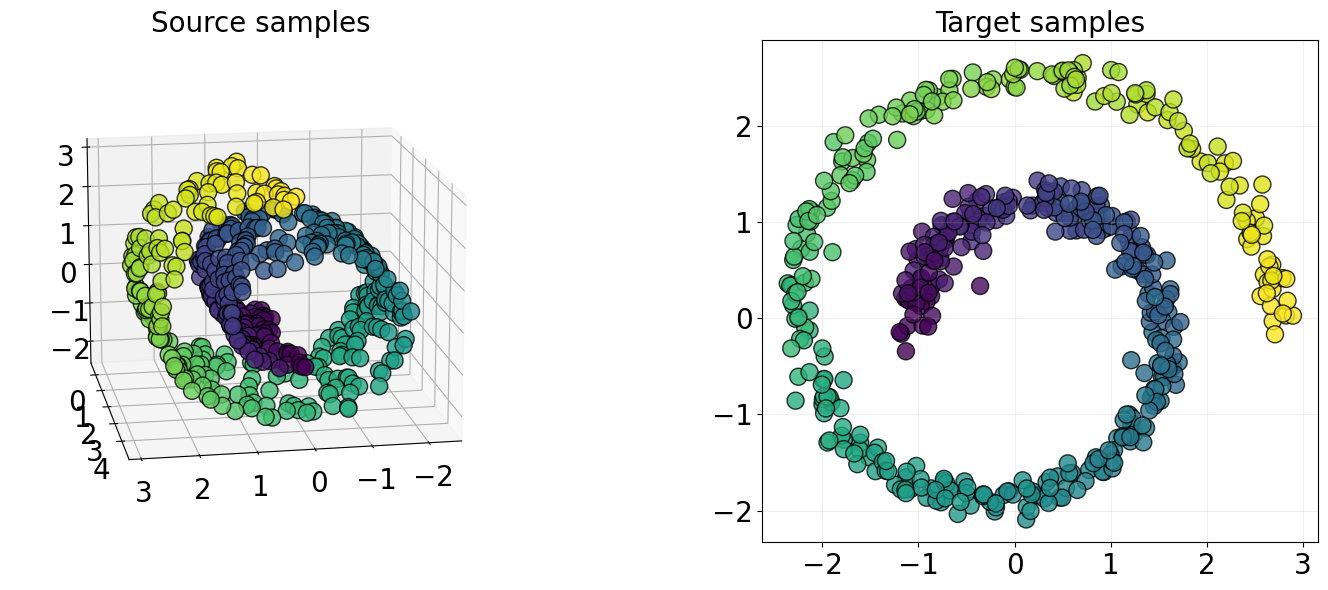

In [25]:


plotter(
    batch=batch, 
    seed=0,
    show=True,
    return_fig=False,
    view_init=(15, 80),
)

In [41]:
const_source = np.repeat(samples_source[0][None,:], 10, axis=0)

In [52]:
const_colors = np.repeat(np.asarray(colors_source[0]), 10, axis=0)

In [45]:
res2, _, _ = otfm.transport(const_source)

In [68]:
source_together = np.concatenate((res[0], res2[0]), axis=0)
colors_together = np.concatenate((colors_source, const_colors), axis=0)

In [71]:
alpha = np.ones((len(colors_together), ))
alpha[:-10] = 0.1
alpha[-10:] = 1.0

In [69]:
batch = {
    "source": samples_source,
    "colors_source": colors_source,
    "target": source_together,
    "colors_target": colors_together,
}

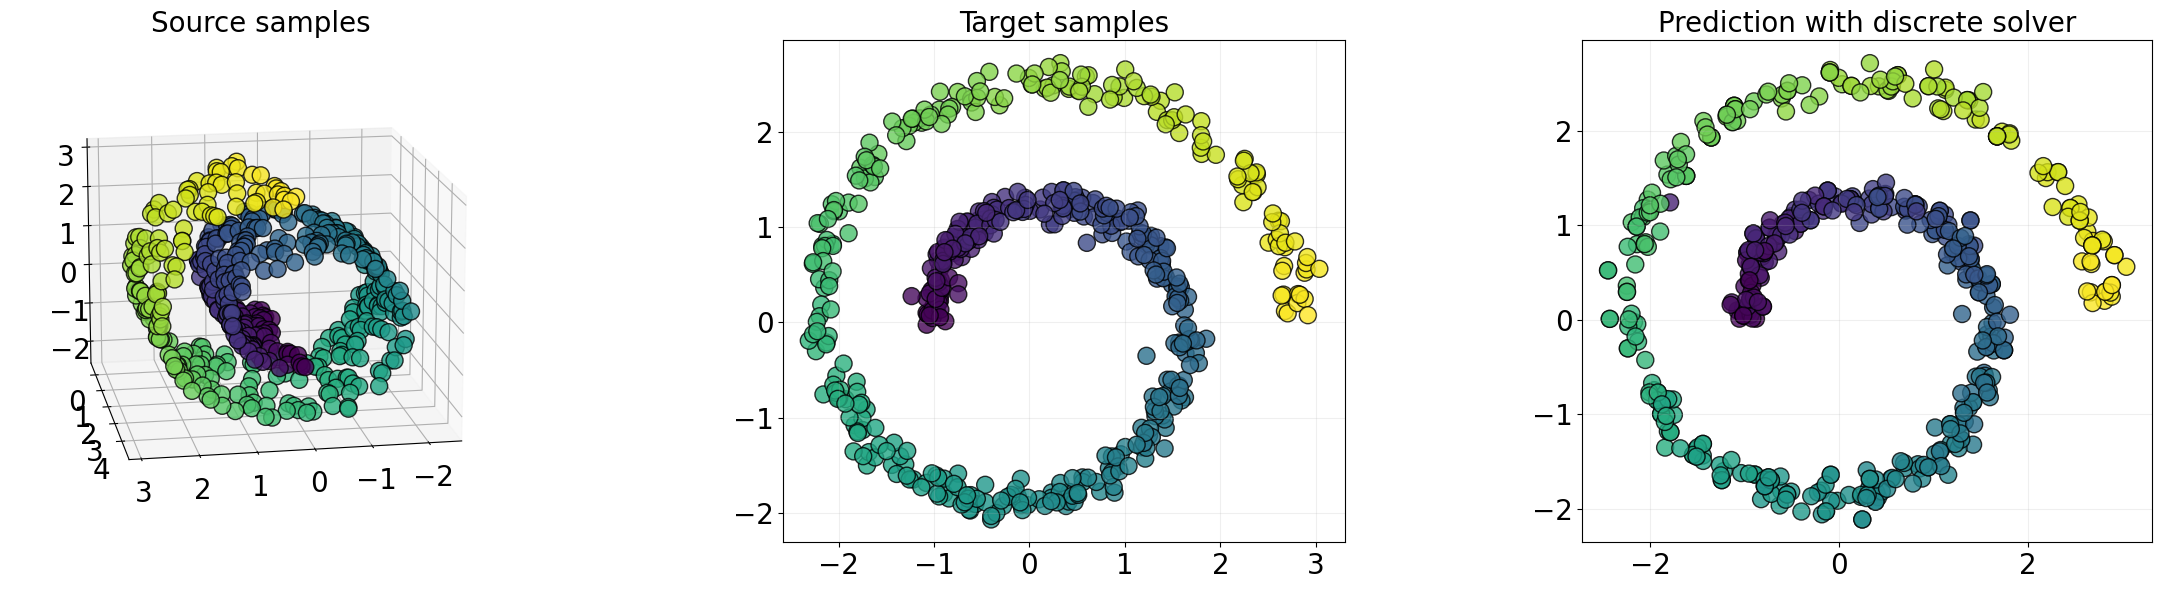

In [75]:
plotter(
    batch=batch, 
    seed=0,
    show=True,
    return_fig=False,
    view_init=(15, 80),
    #alpha=alpha,
)

In [82]:
points.shape

(1034, 2)

In [108]:
source_together.shape

(1034, 2)

In [133]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(5,5), bgcolor='white')
fig.set_facecolor('white') 
points=samples_source
# =============
# First subplot
# =============
# set up the axes for the first plot
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=colors_source,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap="summer",
)
ax1.view_init(15,80)


AttributeError: Figure.set() got an unexpected keyword argument 'bgcolor'

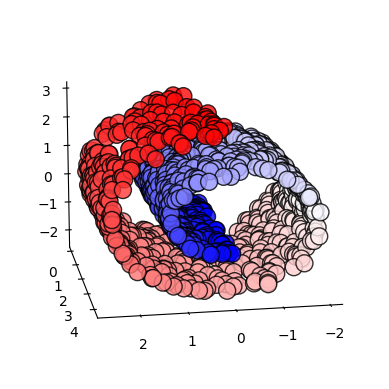

In [145]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure()

# Create a 3D plot with a specified background color
ax1 = fig.add_subplot(1, 1, 1, projection='3d', frame_on=False, )

# Your scatter plot code
ax1.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=colors_source,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap="bwr",
)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax1.xaxis.pane.set_edgecolor('w')
ax1.yaxis.pane.set_edgecolor('w')
ax1.zaxis.pane.set_edgecolor('w')

ax1.grid(False)
ax1.view_init(15, 80)

# Show the plot
plt.show()


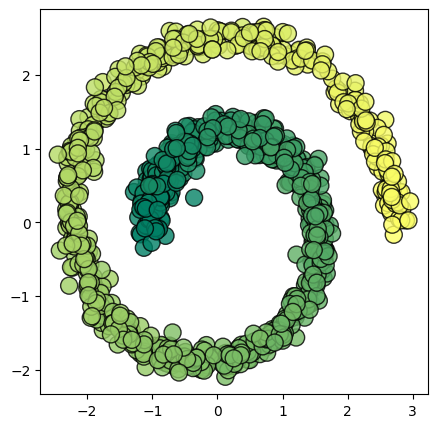

In [128]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(5,5))
points=source_together
col_points=colors_together
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 1,1)
ax.scatter(
    points[:, 0],
    points[:, 1],
    c=col_points,
    edgecolors="k", 
    s=150, 
    alpha=0.8,
    cmap="summer",
)

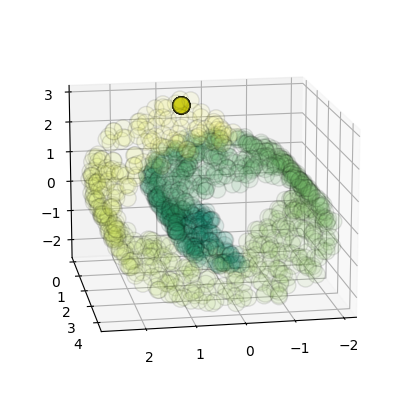

In [127]:
fig = plt.figure(figsize=(5,5))
points=samples_source

ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=colors_source,
    edgecolors="k", 
    s=150, 
    alpha=0.1,
    cmap="summer"
)

ax1.scatter(
    const_source[:, 0],
    const_source[:, 1],
    const_source[:, 2],
    c="r",
    edgecolors="k", 
    s=150, 
    alpha=0.8,
)


ax1.view_init(15,80)


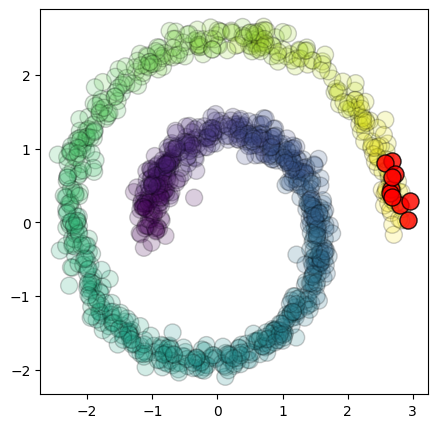

In [117]:
fig = plt.figure(figsize=(5,5))
points=source_together
col_points=colors_together

ax = fig.add_subplot(1, 1,1)
ax.scatter(
    points[:, 0],
    points[:, 1],
    c=col_points,
    edgecolors="k", 
    s=150, 
    alpha=0.1,
)

ax.scatter(
    res2[0][:, 0],
    res2[0][:, 1],
    c="r",
    edgecolors="k", 
    s=150, 
    alpha=0.8,
)